In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
vis_data = pd.read_csv("train.csv", encoding = 'ISO-8859-1', low_memory = False)

In [3]:
vis_data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,M,62,Y,Y,0,0,1,1,2,18000,N,0
1,63161,SCH,F,59,N,N,0,0,3,2,3,19000,N,0
2,25887,SCH,M,25,Y,N,2,0,1,1,2,30000,Y,0
3,16222,SCH,F,53,N,N,0,0,2,2,3,10000,N,0
4,101655,GRD,M,48,N,N,0,1,1,2,3,30000,Y,0



client_id	идентификатор клиента

education	уровень образования

sex	пол заёмщика

age	возраст заёмщика

car	флаг наличия автомобиля

car_type	флаг автомобиля-иномарки

decline_app_cnt	количество отказанных прошлых заявок

good_work	флаг наличия «хорошей» работы

bki_request_cnt	количество запросов в БКИ

home_address	категоризатор домашнего адреса

work_address	категоризатор рабочего адреса

income	доход заёмщика

foreign_passport	наличие загранпаспорта

default	наличие дефолта


In [4]:
vis_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73492 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


In [5]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

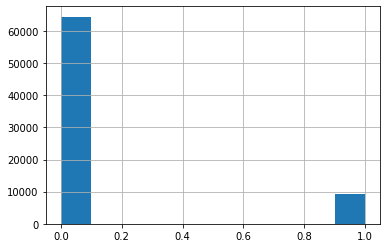

In [6]:
vis_data.default.hist();

In [7]:
vis_data.isnull().sum()

client_id             0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
bki_request_cnt       0
home_address          0
work_address          0
income                0
foreign_passport      0
default               0
dtype: int64

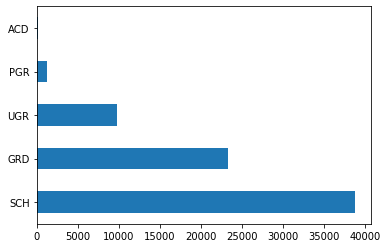

In [8]:
vis_data['education'].value_counts().plot.barh()

In [9]:
vis_data.dropna(axis=0,inplace=True)

In [10]:
vis_data.isnull().sum()

client_id           0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
bki_request_cnt     0
home_address        0
work_address        0
income              0
foreign_passport    0
default             0
dtype: int64

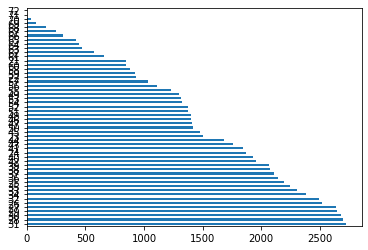

In [11]:
vis_data['age'].value_counts().plot.barh()

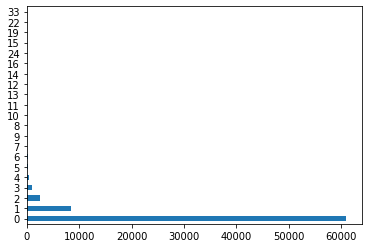

In [12]:
vis_data['decline_app_cnt'].value_counts().plot.barh()

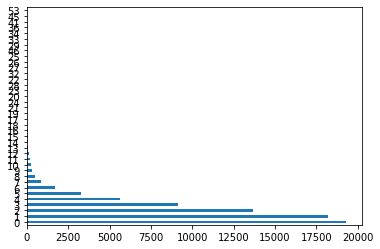

In [13]:
vis_data['bki_request_cnt'].value_counts().plot.barh()

In [37]:
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

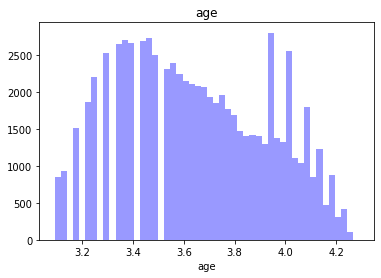

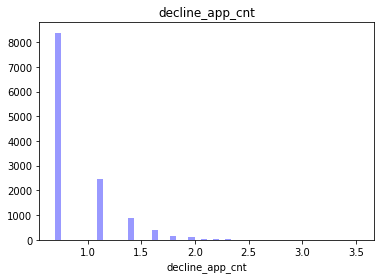

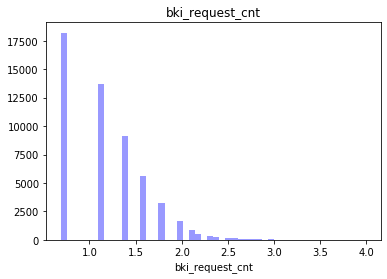

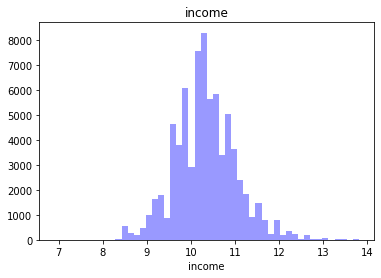

In [38]:
for i in num_cols:
    vis_data[i] = np.log(vis_data[i] + 1)
    plt.figure()
    sns.distplot(vis_data[i][vis_data[i] > 0].dropna(), kde = False, rug=False, color='b')
    plt.title(i)
    plt.show()
    

In [47]:
m=vis_data['default'].value_counts() 
print("Общее количество \n", m)
print("Общее количество дефолтных:", m[1])

Общее количество 
 0    64155
1     9337
Name: default, dtype: int64
Общее количество дефолтных: 9337


In [48]:
default_group=vis_data.groupby('default') 

In [49]:
default_group['age'].value_counts()

default  age     
0        3.465736    2376
         3.367296    2335
         3.433987    2312
         3.401197    2283
         3.332205    2278
                     ... 
1        4.234107      27
         4.219508      25
         4.248495       7
         4.262680       7
         4.290459       1
Name: age, Length: 102, dtype: int64

In [50]:
default_group['decline_app_cnt'].value_counts()

default  decline_app_cnt
0        0.000000           54254
         0.693147            6806
         1.098612            1864
         1.386294             656
         1.609438             294
         1.791759             122
         1.945910              79
         2.079442              34
         2.302585              15
         2.197225               9
         2.397895               6
         2.484907               6
         2.639057               3
         2.564949               2
         2.833213               2
         2.708050               1
         3.218876               1
         3.526361               1
1        0.000000            6677
         0.693147            1573
         1.098612             600
         1.386294             245
         1.609438             120
         1.791759              43
         1.945910              34
         2.079442              14
         2.197225              10
         2.302585               9
         2.397895      

In [51]:
default_group['bki_request_cnt'].value_counts()

default  bki_request_cnt
0        0.000000           17454
         0.693147           16035
         1.098612           11884
         1.386294            7818
         1.609438            4761
                            ...  
1        3.401197               1
         3.496508               1
         3.737670               1
         3.828641               1
         3.850148               1
Name: bki_request_cnt, Length: 64, dtype: int64

In [52]:
default_group['income'].value_counts()

default  income   
0        10.308986    6110
         10.126671    5202
         9.903538     4645
         10.596660    4333
         10.819798    4016
                      ... 
1        12.468441       1
         12.506181       1
         13.527830       1
         13.592368       1
         13.629182       1
Name: income, Length: 1230, dtype: int64

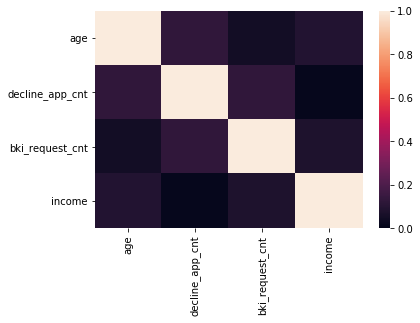

In [53]:
sns.heatmap(vis_data[num_cols].corr().abs(), vmin=0, vmax=1)

In [54]:
vis_data.corr()

,client_id,age,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,default
client_id,1.000000,0.017123,-0.023092,0.004616,-0.010210,0.165564,0.165830,0.005097,-0.039165
age,0.017123,1.000000,-0.127779,-0.073256,0.049576,-0.000353,-0.016018,-0.092507,-0.026057
decline_app_cnt,-0.023092,-0.127779,1.000000,-0.032719,0.125070,0.011622,0.017971,-0.013689,0.123847
good_work,0.004616,-0.073256,-0.032719,1.000000,0.006097,-0.003633,-0.008663,0.051344,-0.043715
bki_request_cnt,-0.010210,0.049576,0.125070,0.006097,1.000000,0.004197,0.000691,0.080796,0.078899
home_address,0.165564,-0.000353,0.011622,-0.003633,0.004197,1.000000,0.728337,0.047242,0.085102
work_address,0.165830,-0.016018,0.017971,-0.008663,0.000691,0.728337,1.000000,0.068508,0.082118
income,0.005097,-0.092507,-0.013689,0.051344,0.080796,0.047242,0.068508,1.000000,-0.053621
default,-0.039165,-0.026057,0.123847,-0.043715,0.078899,0.085102,0.082118,-0.053621,1.000000


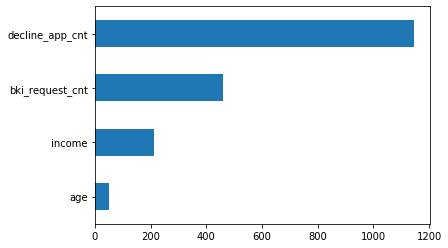

In [55]:
imp_num = Series(f_classif(vis_data[num_cols], vis_data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [57]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(vis_data['sex']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}


In [59]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in num_cols:
    vis_data[column] = label_encoder.fit_transform(vis_data[column])
    
# убедимся в преобразовании    
vis_data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,M,41,Y,Y,0,0,1,1,2,321,N,0
1,63161,SCH,F,38,N,N,0,0,3,2,3,335,N,0
2,25887,SCH,M,4,Y,N,2,0,1,1,2,496,Y,0
3,16222,SCH,F,32,N,N,0,0,2,2,3,150,N,0
4,101655,GRD,M,27,N,N,0,1,1,2,3,496,Y,0


In [61]:
imp_cat = Series(mutual_info_classif(vis_data[num_cols + cat_cols], vis_data['default'],discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

NameError: name 'cat_cols' is not defined

In [64]:
X_cat = OneHotEncoder(sparse = False).fit_transform(vis_data[cat_cols].values)

NameError: name 'cat_cols' is not defined

In [65]:
X_num = StandardScaler().fit_transform(vis_data[num_cols].values)

In [67]:
X = np.hstack([X_num, vis_data[num_cols].values, X_cat])
Y = vis_data['default'].values

NameError: name 'X_cat' is not defined

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

NameError: name 'X' is not defined

In [69]:
model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

NameError: name 'X_train' is not defined

In [70]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

NameError: name 'X_train' is not defined